 Data Processing

In [1]:
import pandas as pd
import json

def load_data(filepath, file_type):
    if file_type == 'csv':
        return pd.read_csv(filepath)
    elif file_type == 'json':
        with open(filepath, 'r') as f:
            data = json.load(f)
        return pd.json_normalize(data)
    elif file_type == 'excel':
        return pd.read_excel(filepath)
    else:
        raise ValueError("Unsupported file type")

# Example usage
data = load_data('/content/olympics2024.csv', 'csv')
print(data.head())


   Rank        Country Country Code  Gold  Silver  Bronze  Total
0     1  United States           US    40      44      42    126
1     2          China          CHN    40      27      24     91
2     3          Japan          JPN    20      12      13     45
3     4      Australia          AUS    18      19      16     53
4     5         France          FRA    16      26      22     64


Data Cleaning

In [2]:
def handle_missing_values(df, strategy='mean'):
    # Select only numeric columns
    numeric_cols = df.select_dtypes(include=['number']).columns

    if strategy == 'mean':
        df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
    elif strategy == 'median':
        df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
    elif strategy == 'drop':
        df = df.dropna()
    elif strategy == 'ffill':
        df[numeric_cols] = df[numeric_cols].fillna(method='ffill')
    elif strategy == 'bfill':
        df[numeric_cols] = df[numeric_cols].fillna(method='bfill')
    else:
        raise ValueError("Unsupported strategy")

    return df

# Example usage
cleaned_data = handle_missing_values(data, 'mean')
print(cleaned_data.head())

   Rank        Country Country Code  Gold  Silver  Bronze  Total
0     1  United States           US    40      44      42    126
1     2          China          CHN    40      27      24     91
2     3          Japan          JPN    20      12      13     45
3     4      Australia          AUS    18      19      16     53
4     5         France          FRA    16      26      22     64


In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def scale_data(df, method='standard'):
    # Select only numeric columns
    numeric_cols = df.select_dtypes(include=['number']).columns

    # Initialize the scaler
    if method == 'standard':
        scaler = StandardScaler()
    elif method == 'minmax':
        scaler = MinMaxScaler()
    else:
        raise ValueError("Unsupported scaling method")

    # Scale only the numeric columns
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    return df


scaled_data = scale_data(cleaned_data)
print(scaled_data.head())


       Rank        Country Country Code      Gold    Silver    Bronze  \
0 -1.736814  United States           US  5.235449  6.000820  5.792149   
1 -1.697615          China          CHN  5.235449  3.476135  3.032538   
2 -1.658416          Japan          JPN  2.358481  1.248471  1.346110   
3 -1.619217      Australia          AUS  2.070785  2.288047  1.806045   
4 -1.580018         France          FRA  1.783088  3.327624  2.725915   

      Total  
0  5.847751  
1  4.061514  
2  1.713889  
3  2.122172  
4  2.683561  


In [4]:
import pandas as pd
import numpy as np

def remove_outliers(df, method='iqr'):
    # Select only numeric columns
    numeric_cols = df.select_dtypes(include=['number']).columns

    if method == 'iqr':
        Q1 = df[numeric_cols].quantile(0.25)
        Q3 = df[numeric_cols].quantile(0.75)
        IQR = Q3 - Q1
        # Filter the rows that are within the IQR range
        df = df[~((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
    elif method == 'zscore':
        from scipy import stats
        z_scores = np.abs(stats.zscore(df[numeric_cols]))
        # Keep rows where the z-score is less than 3 (a common threshold)
        df = df[(z_scores < 3).all(axis=1)]
    else:
        raise ValueError("Unsupported method")

    return df


data_no_outliers = remove_outliers(scaled_data)
print(data_no_outliers.head())


        Rank  Country Country Code      Gold    Silver    Bronze     Total
13 -1.227228  Hungary          HUN  0.344604  0.505916  0.272928  0.386971
14 -1.188029    Spain          SPA  0.200755  0.060384  0.732863  0.335936
15 -1.148830   Sweden          SWE  0.056907  0.060384 -0.187007 -0.021311
16 -1.109631    Kenya          KEN  0.056907 -0.236638  0.119617 -0.021311
17 -1.070432   Norway          NOR  0.056907 -0.385149 -0.187007 -0.174417


Analysis Engine

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

def analyze_data(df):
    # Example 1: Linear Regression
    X = df[['Gold', 'Silver', 'Bronze']]
    y = df['Total']
    model = LinearRegression()
    model.fit(X, y)
    print("Linear Regression Coefficients:", model.coef_)

    # Example 2: K-Means Clustering
    kmeans = KMeans(n_clusters=3)
    clusters = kmeans.fit_predict(df[['Gold', 'Silver', 'Bronze']])
    df['Cluster'] = clusters
    print("K-Means Clustering:", df['Cluster'].value_counts())

    # Example 3: PCA for Dimensionality Reduction
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(df[['Gold', 'Silver', 'Bronze']])
    print("PCA Components:", principal_components[:5])

# Example usage
analyze_data(data_no_outliers)


Linear Regression Coefficients: [0.35478548 0.34364692 0.33288609]
K-Means Clustering: Cluster
0    52
2    19
1     6
Name: count, dtype: int64
PCA Components: [[ 1.12314521  0.44063709]
 [ 1.2182645  -0.20128039]
 [ 0.43694705  0.29298752]
 [ 0.53905562 -0.12097337]
 [ 0.22847297 -0.0703318 ]]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
<ipython-input-5-cbf2d3208e1b>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster'] = clusters


Report Generation


Summary Statistics:
             Rank       Gold     Silver     Bronze      Total    Cluster
count  77.000000  77.000000  77.000000  77.000000  77.000000  77.000000
mean    0.266404  -0.335407  -0.317644  -0.316425  -0.333489   0.571429
std     0.850373   0.197506   0.234254   0.290106   0.192916   0.864939
min    -1.227228  -0.518487  -0.533660  -0.646942  -0.531665   0.000000
25%    -0.443249  -0.518487  -0.533660  -0.493630  -0.480629   0.000000
50%     0.262331  -0.374638  -0.385149  -0.340318  -0.378559   0.000000
75%     1.046310  -0.230790  -0.236638  -0.187007  -0.225453   1.000000
max     1.516697   0.344604   0.505916   0.732863   0.386971   2.000000


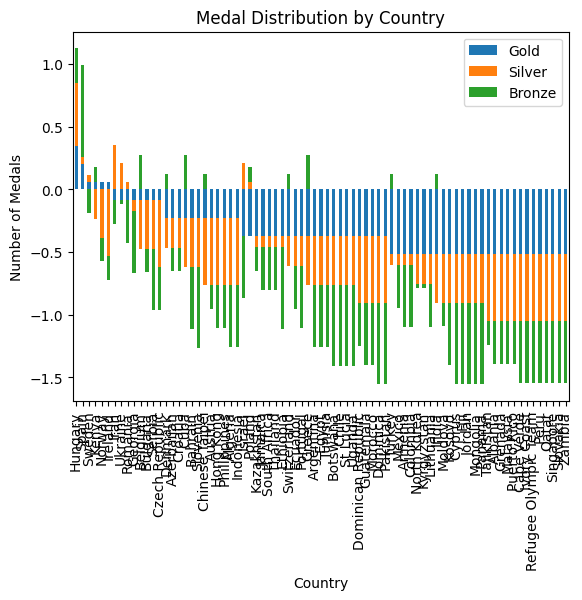

In [6]:
import matplotlib.pyplot as plt

def generate_report(df):
    # Generate a summary
    summary = df.describe()
    print("Summary Statistics:\n", summary)

    # Visualize the data
    df.plot(kind='bar', x='Country', y=['Gold', 'Silver', 'Bronze'], stacked=True)
    plt.title('Medal Distribution by Country')
    plt.xlabel('Country')
    plt.ylabel('Number of Medals')
    plt.show()

# Example usage
generate_report(data_no_outliers)


<ipython-input-8-4b9c80101128>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PCA1'] = components[:, 0]
<ipython-input-8-4b9c80101128>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PCA2'] = components[:, 1]


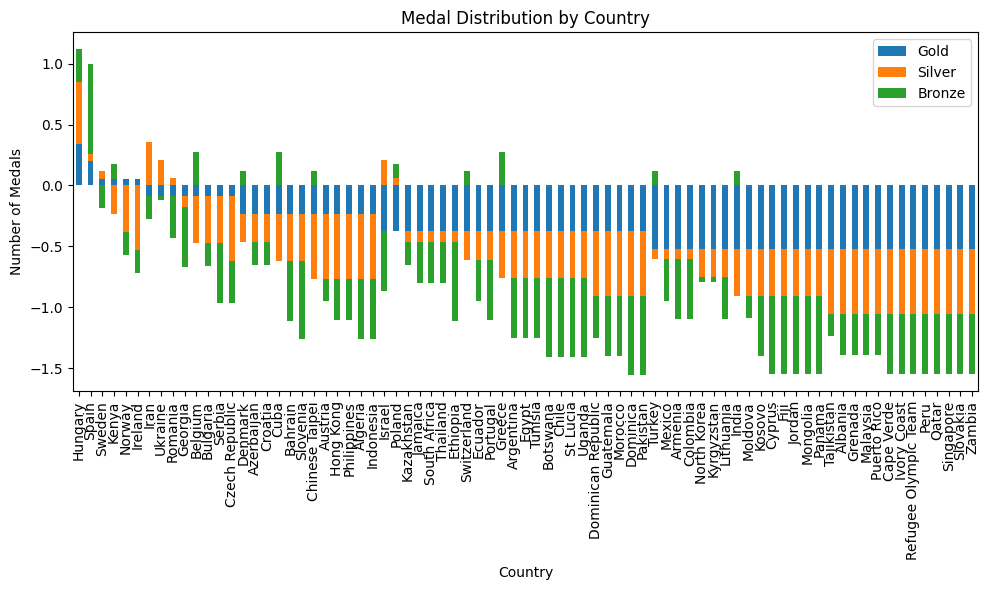

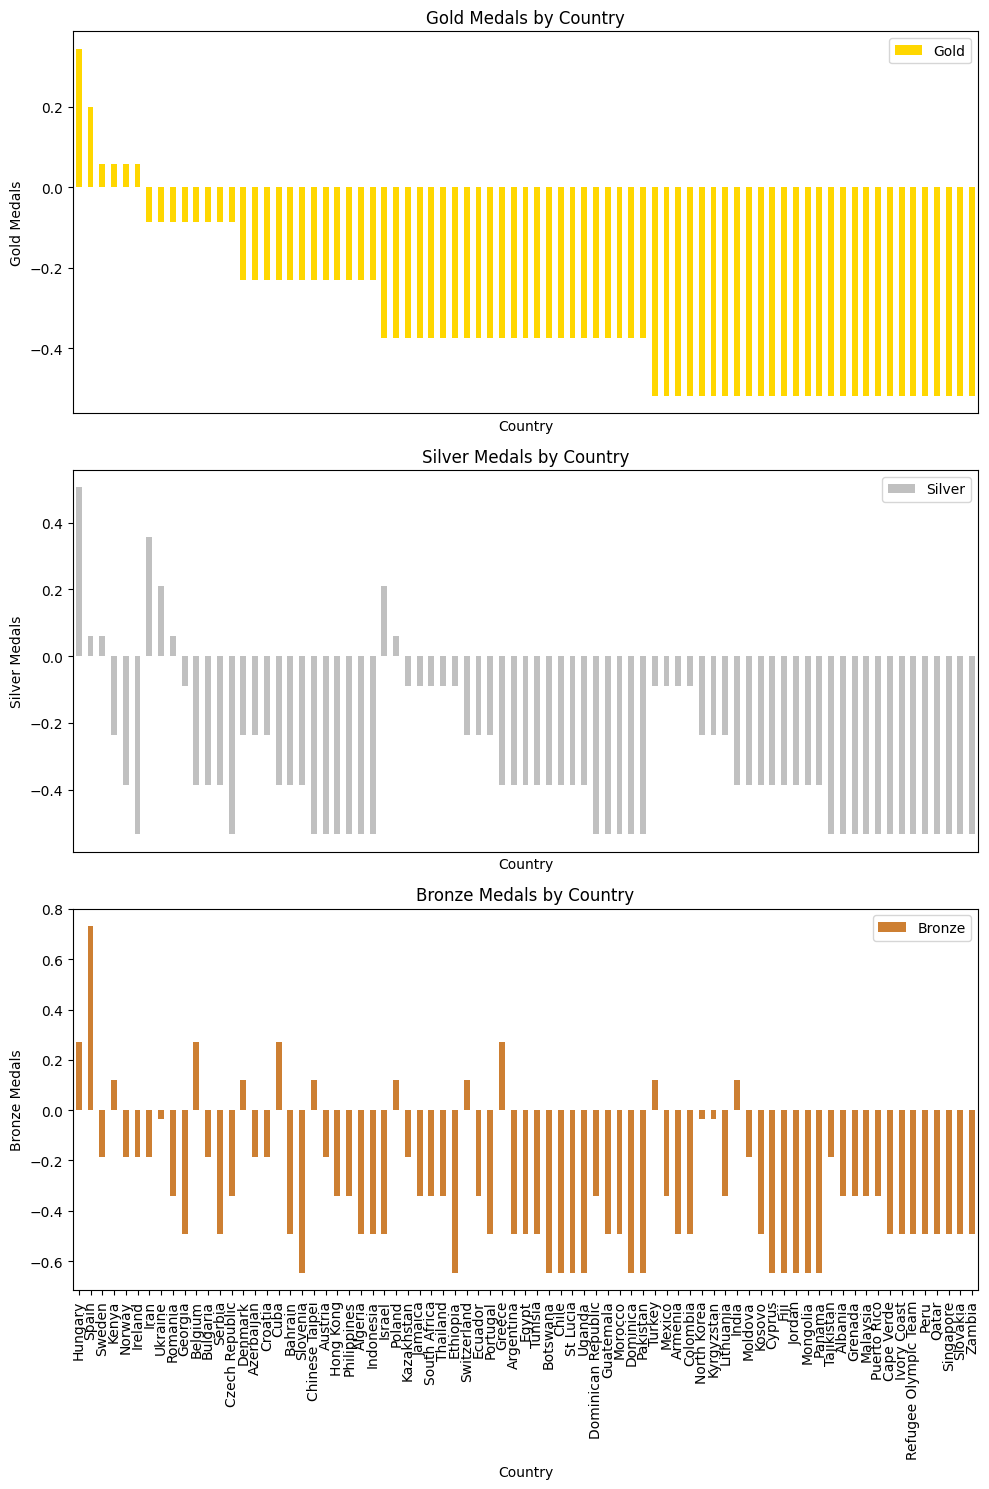

<ipython-input-8-4b9c80101128>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster_Label'] = df['Cluster'].map(cluster_labels)


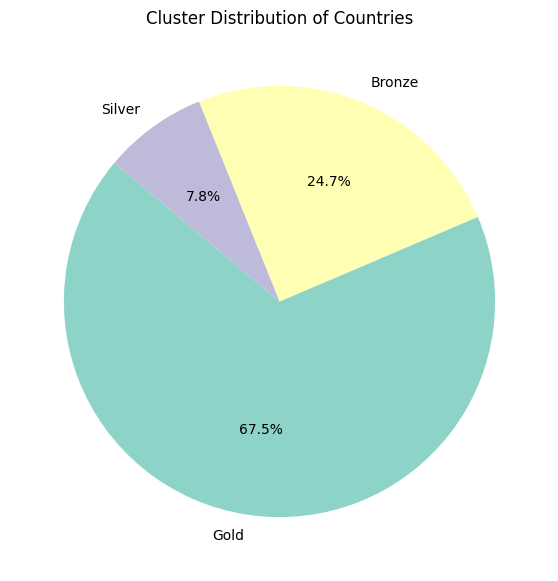

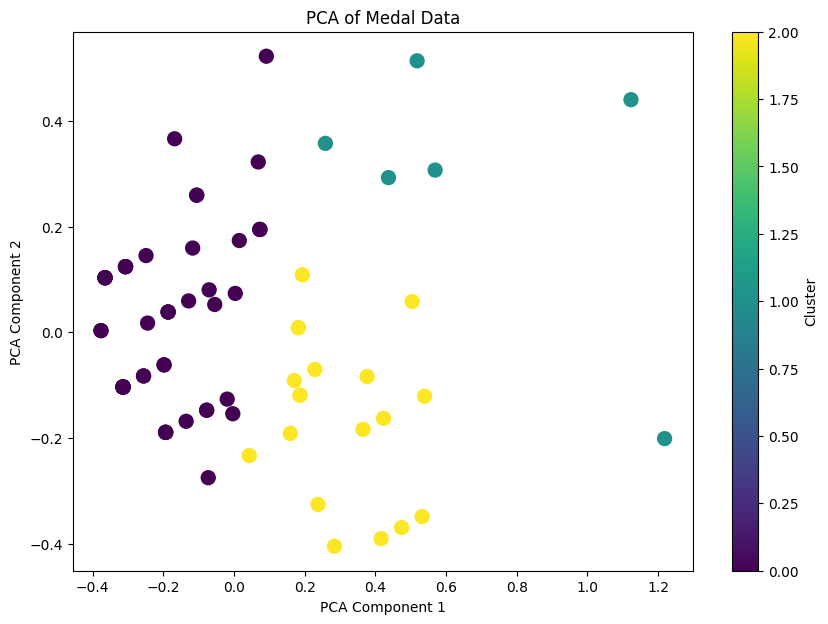

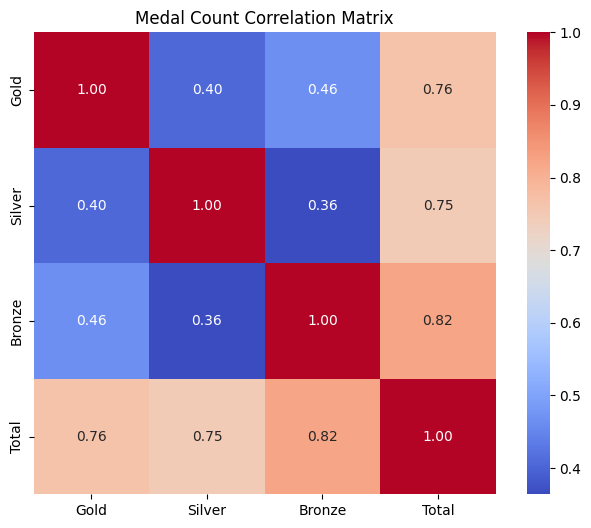

In [8]:
from sklearn.decomposition import PCA
import seaborn as sns
# Perform PCA
def perform_pca(df):
    pca = PCA(n_components=2)
    components = pca.fit_transform(df[['Gold', 'Silver', 'Bronze']])
    df['PCA1'] = components[:, 0]
    df['PCA2'] = components[:, 1]
    return df

# Apply PCA to the cleaned and scaled data
data_with_pca = perform_pca(data_no_outliers)

def generate_report(df):
    # 1. Medal Distribution by Country (Stacked Bar Chart)
    df.plot(kind='bar', x='Country', y=['Gold', 'Silver', 'Bronze'], stacked=True, figsize=(10, 6))
    plt.title('Medal Distribution by Country')
    plt.xlabel('Country')
    plt.ylabel('Number of Medals')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    # 2. Gold, Silver, and Bronze Medals by Country (Separate Bar Charts)
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))

    df.plot(kind='bar', x='Country', y='Gold', ax=axs[0], color='gold')
    axs[0].set_title('Gold Medals by Country')
    axs[0].set_ylabel('Gold Medals')
    axs[0].set_xticks([])

    df.plot(kind='bar', x='Country', y='Silver', ax=axs[1], color='silver')
    axs[1].set_title('Silver Medals by Country')
    axs[1].set_ylabel('Silver Medals')
    axs[1].set_xticks([])

    df.plot(kind='bar', x='Country', y='Bronze', ax=axs[2], color='#cd7f32')
    axs[2].set_title('Bronze Medals by Country')
    axs[2].set_ylabel('Bronze Medals')
    axs[2].set_xticks(range(len(df['Country'])))
    axs[2].set_xticklabels(df['Country'], rotation=90)

    plt.tight_layout()
    plt.show()

    # 3. Cluster Distribution (Pie Chart)
    cluster_labels = {0: 'Gold', 1: 'Silver', 2: 'Bronze'}
    df['Cluster_Label'] = df['Cluster'].map(cluster_labels)

    cluster_counts = df['Cluster_Label'].value_counts()
    plt.figure(figsize=(7, 7))
    plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set3"))
    plt.title('Cluster Distribution of Countries')
    plt.show()

    # 4. PCA Visualization (2D Scatter Plot)
    plt.figure(figsize=(10, 7))
    plt.scatter(df['PCA1'], df['PCA2'], c=df['Cluster'], cmap='viridis', s=100)
    plt.title('PCA of Medal Data')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(label='Cluster')
    plt.show()

    # 5. Medal Count Correlation Matrix (Heatmap)
    plt.figure(figsize=(8, 6))
    correlation_matrix = df[['Gold', 'Silver', 'Bronze', 'Total']].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True, square=True, fmt='.2f')
    plt.title('Medal Count Correlation Matrix')
    plt.show()

# Example usage
generate_report(data_with_pca)


User Interaction

In [13]:
import re

def user_interface():
    print("Welcome to the AI Employee for Data Analysis and Reporting!")
    while True:
        query = input("Please enter your query or type 'exit' to quit: ").lower()
        if query == 'exit':
            break
        elif re.search(r'top.*country.*medal', query):
            top_country = scaled_data.nlargest(1, 'Total')['Country'].values[0]
            print(f"The top country by total medals is: {top_country}")

        else:
            print("Sorry, I didn't understand that query. Please try again.")

# Example usage
user_interface()


Welcome to the AI Employee for Data Analysis and Reporting!
Please enter your query or type 'exit' to quit: top.*country.*medal
The top country by total medals is: United States
Please enter your query or type 'exit' to quit: exit


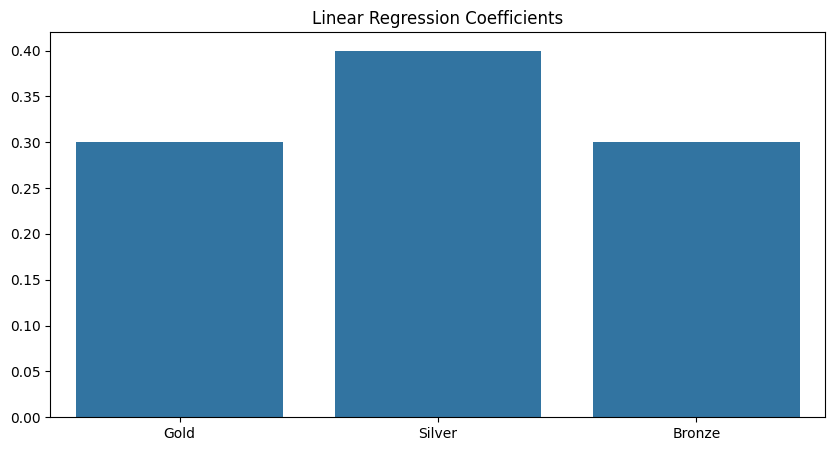

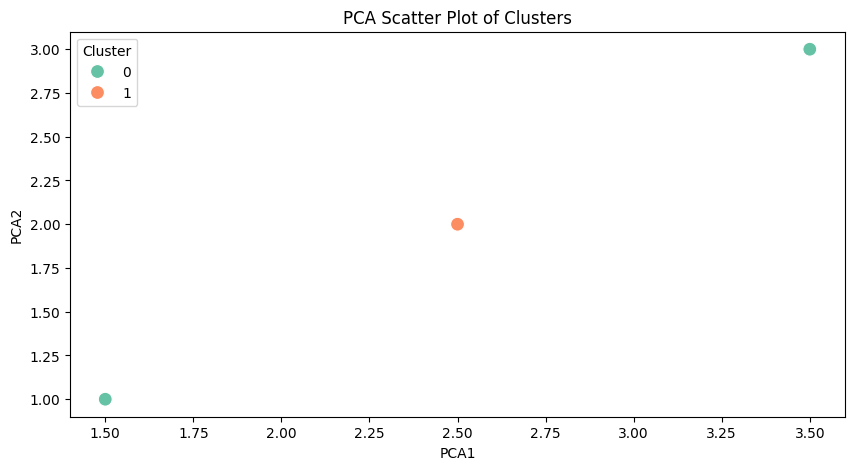

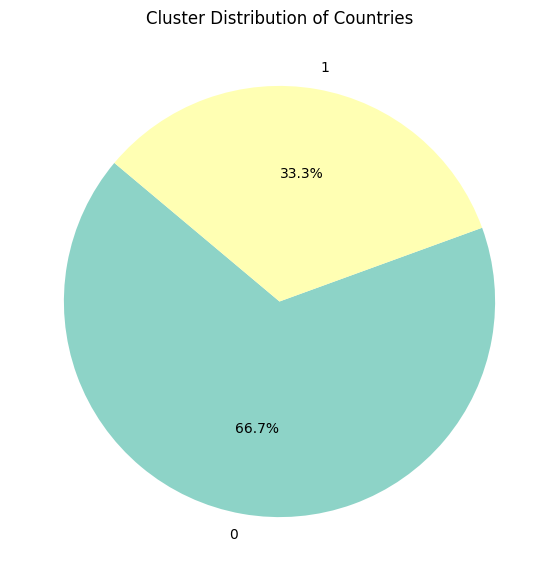

Report generation test passed.


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

def test_generation():
    # Sample test data
    test_df = pd.DataFrame({
        'Country': ['India', 'USA', 'UK'],
        'Gold': [10, 20, 15],
        'Silver': [5, 10, 7],
        'Bronze': [3, 6, 5],
        'Total': [18, 36, 27],
        'Cluster': [0, 1, 0],
        'PCA1': [1.5, 2.5, 3.5],
        'PCA2': [1.0, 2.0, 3.0]
    })

    try:
        # Linear Regression Coefficients Plot
        plt.figure(figsize=(10, 5))
        sns.barplot(x=['Gold', 'Silver', 'Bronze'], y=[0.3, 0.4, 0.3])
        plt.title('Linear Regression Coefficients')
        plt.show()

        # PCA Scatter Plot
        plt.figure(figsize=(10, 5))
        sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=test_df, palette="Set2", s=100)
        plt.title('PCA Scatter Plot of Clusters')
        plt.show()

        # Cluster Distribution Pie Chart
        cluster_counts = test_df['Cluster'].value_counts()
        plt.figure(figsize=(7, 7))
        plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set3"))
        plt.title('Cluster Distribution of Countries')
        plt.show()

        print("Report generation test passed.")
    except Exception as e:
        print(f"Report generation test failed: {e}")

# Run the report generation test
test_generation()
